# Logistic Regression: Kid Creative magazine

given information about our customers, we predict whether they will buy _Kid Creative_

first, we import our main math stuff

In [7]:
%pip install seaborn

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-pastel')
import seaborn as sns
import math

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


now, we load our dataset

In [8]:
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('kid_creative.csv')

print('raw data:')
print(dataset.dtypes)

# split labels and features
labels = dataset['Buy'] # just the Buy column
features = dataset.iloc[:, 2:16] # take all rows, cols 2-16

# partition our data
x_raw = features
y_raw = np.ravel(labels)

x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.3, random_state=42)

print('training data shape:', x_train.shape)

raw data:
Obs No.             int64
Buy                 int64
Income              int64
Is Female           int64
Is Married          int64
Has College         int64
Is Professional     int64
Is Retired          int64
Unemployed          int64
Residence Length    int64
Dual Income         int64
Minors              int64
Own                 int64
House               int64
White               int64
English             int64
Prev Child Mag      int64
Prev Parent Mag     int64
dtype: object
training data shape: (471, 14)


let's do a sanity check on the data, by visualizing part of it

<AxesSubplot:xlabel='Residence Length'>

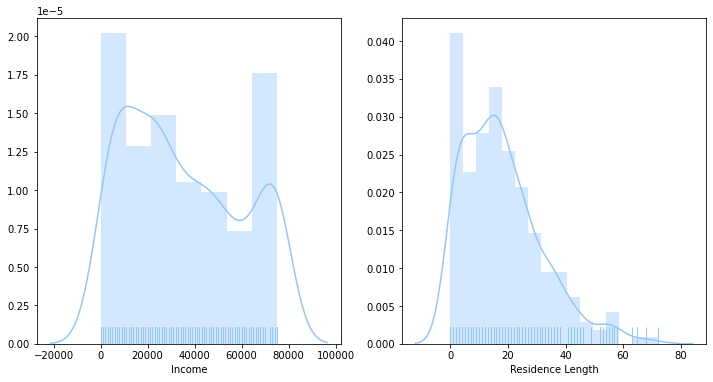

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.distplot(x_train['Income'], ax=ax[0], rug=True)
sns.distplot(x_train['Residence Length'], ax=ax[1], rug=True)

now, we're going to prepare our data

In [10]:
from sklearn.preprocessing import StandardScaler

# normalize our features
scaler = StandardScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

now, we define our model architecture. we iterate on this based on our experimental runs.

In [11]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(48, activation='selu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(48, activation='selu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

build_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 48)                720       
_________________________________________________________________
dropout_3 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 48)                2352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 49        
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


here, we define some variables (such as the number of epochs) and plot the performance metrics of the model. using these graphs we can see where we start to overfit, and our validation set performance drops.
we iterate on the model until we reach a suitable level of performance on the validation set.



0epoch [00:00, ?epoch/s]

  0%|          | 0/400 [00:00<?, ?epoch/s]

  0%|          | 2/400 [00:00<00:22, 17.91epoch/s, val_loss=0.402, val_acc=0.812, loss=0.508, acc=0.758]performing exploratory training: 400 epochs...


  1%|▏         | 5/400 [00:00<00:20, 19.02epoch/s, val_loss=0.251, val_acc=0.926, loss=0.344, acc=0.849]

  2%|▏         | 8/400 [00:00<00:19, 19.95epoch/s, val_loss=0.192, val_acc=0.941, loss=0.263, acc=0.877]

  3%|▎         | 11/400 [00:00<00:18, 20.98epoch/s, val_loss=0.17, val_acc=0.946, loss=0.251, acc=0.887]

  4%|▎         | 14/400 [00:00<00:17, 21.59epoch/s, val_loss=0.155, val_acc=0.95, loss=0.225, acc=0.911]

  4%|▍         | 17/400 [00:00<00:18, 21.23epoch/s, val_loss=0.145, val_acc=0.955, loss=0.183, acc=0.926]

  5%|▍         | 19/400 [00:00<00:18, 20.52epoch/s, val_loss=0.144, val_acc=0.96, loss=0.207, acc=0.902]

  6%|▌         | 22/400 [00:01<00:17, 21.03epoch/s, val_loss=0.138, val_acc=0.955, loss=0.186, acc=0.921]

  6%|▋         | 25/400 [00:01<

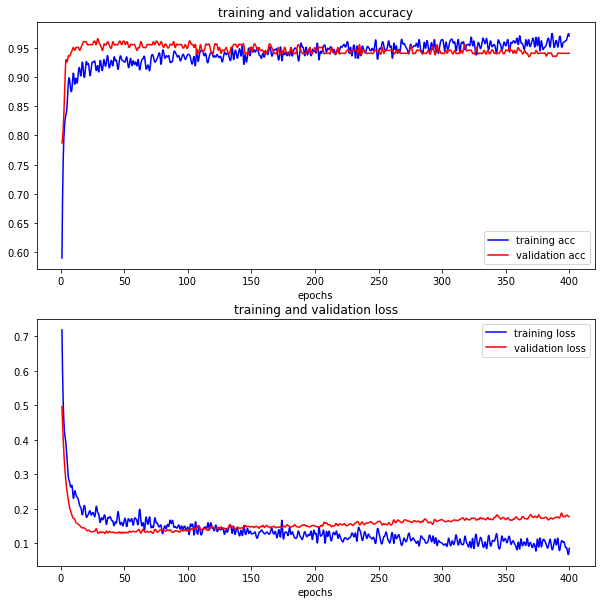

In [21]:
from tqdm.keras import TqdmCallback
from scipy.interpolate import make_interp_spline

batch_size = 32
explore_epochs = 400

model = build_model()

print(f'performing exploratory training: {explore_epochs} epochs...')

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=explore_epochs, batch_size=32, verbose=0, callbacks=[TqdmCallback(verbose=0)])

train_acc_hst = hist.history['acc']
val_acc_hst = hist.history['val_acc']
train_loss_hst = hist.history['loss']
val_loss_hst = hist.history['val_loss']

skip_epochs = 0
epoch_range = range(skip_epochs + 1, len(train_acc_hst) + 1)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

def smooth(raw_range, raw_series, interp):
    a_range = np.array(raw_range)
    a_series = np.array(raw_series)
    smooth_range = np.linspace(a_range.min(), a_range.max(), a_range.shape[0] * interp)
    spl = make_interp_spline(a_range, a_series, k=3) # cubic BSpline
    smooth_series = spl(smooth_range)

    return smooth_range, smooth_series

ax[0].plot(*smooth(epoch_range, train_acc_hst[skip_epochs:], 4), 'b-', label='training acc')
ax[0].plot(*smooth(epoch_range, val_acc_hst[skip_epochs:], 4), 'r-', label='validation acc')
ax[0].set_title("training and validation accuracy")
ax[0].set_xlabel("epochs")
ax[0].legend()

ax[1].plot(*smooth(epoch_range, train_loss_hst[skip_epochs:], 4), 'b-', label='training loss')
ax[1].plot(*smooth(epoch_range, val_loss_hst[skip_epochs:], 4), 'r-', label='validation loss')
ax[1].set_title('training and validation loss')
ax[1].set_xlabel("epochs")
ax[1].legend()

now, based on our tweaked model and findings for a good number of epochs, we train our final model, and evaluate it on the test set.

In [9]:
from tqdm.keras import TqdmCallback

batch_size = 32
epochs = 120

model = build_model()
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[TqdmCallback(verbose=0)])

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', test_loss)
print('test acc:', test_acc)

100%|██████████| 120/120 [00:04<00:00, 26.94epoch/s, loss=0.154, acc=0.917]test loss: 0.1340695849739679
test acc: 0.9554455445544554

